In [66]:
import warnings
from pathlib import Path

import iris
import iris.cube
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator
from matplotlib import cm
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")

In [67]:
# Parameters
metallicity = "solar"
t0 = 80  # 80th slice of 10-day-frequency output, i.e. 800 day
tgt_plevs = np.logspace(7, 2, 66)  # target pressure levels
tgt_lats = [0, 60]  # target latitudes
tgt_lons = np.arange(0, 360, 30) #+ 1.25  # target longitudes*
interp_args = ([("latitude", tgt_lats), ("longitude", tgt_lons)], iris.analysis.Linear())
# *in the UM v11.4 substellar point in radiation is shifted 1.25 degrees east

In [68]:
DATA_DIR = Path.cwd().parent / "cylc-run" / "u-cp389" / "work" / "1" / "atmos_base_0000"
data_file = DATA_DIR / "atmosa.pb00000000_00"
pd0 = iris.load(data_file)

print(pd0)

0: air_pressure / (Pa)                 (time: 3; model_level_number: 67; latitude: 90; longitude: 144)
1: air_temperature / (K)               (time: 3; model_level_number: 66; latitude: 90; longitude: 144)


In [69]:
pres_data = pd0.extract_cube("air_pressure")
temp_data = pd0.extract_cube("air_temperature")
# print(pres_data)
# print(temp_data)

In [70]:
temp_data_collapsed = temp_data.collapsed("time", iris.analysis.MEAN)
print(temp_data_collapsed.shape)
print(pres_data.shape)

(66, 90, 144)
(3, 67, 90, 144)


In [71]:
pres_data_cut1 = pres_data[2, 0:66,:]
pres_data_cut1.shape

(66, 90, 144)

In [72]:
temp_plevs = interp_cube_from_height_to_pressure_levels(temp_data_collapsed, pres_data_cut1, tgt_plevs)
temp_plevs_locs = temp_plevs.interpolate(*interp_args)
pres_coord = temp_plevs_locs.coord("air_pressure")

In [73]:
# Find initial pressure-temperature profiles created using ATMO
init_pt_path = Path.cwd().parent / "roses" / "data" / "WASP-96b_PT_EQ_MdH1.ncdf"

init_pres_vp = iris.load_cube(str(init_pt_path), "pressure_si")
init_temp_vp = iris.load_cube(str(init_pt_path), "temperature")
# Select initial pressure-temperature profile data between 1e2-1e7 Pa
pres_1e2_1e7 = np.where((init_pres_vp.data <= 1e7) & (init_pres_vp.data >= 1e2))
init_pres_1e2_1e7 = init_pres_vp[pres_1e2_1e7]
init_temp_1e2_1e7 = init_temp_vp[pres_1e2_1e7]

In [102]:
# Find initial pressure-temperature profiles created using ATMO
init_pt_path_s = Path.cwd().parent / "roses" / "data" / "WASP-96b_PT_EQ.ncdf"

init_pres_vp_s = iris.load_cube(str(init_pt_path_s), "pressure_si")
init_temp_vp_s = iris.load_cube(str(init_pt_path_s), "temperature")
# Select initial pressure-temperature profile data between 1e2-1e7 Pa
pres_1e2_1e7_s = np.where((init_pres_vp_s.data <= 1e7) & (init_pres_vp_s.data >= 1e2))
init_pres_1e2_1e7_s = init_pres_vp_s[pres_1e2_1e7_s]
init_temp_1e2_1e7_s = init_temp_vp_s[pres_1e2_1e7_s]

In [79]:
init_pres_1e2_1e7

Pressure Si (unknown),--
Shape,35


In [74]:
# Plotting parameters
# Sample each colormap 4 times but use the brightest 3 colours from each colormap
nclrs = 4
clrs_1 = plt.cm.Blues_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_2 = plt.cm.Oranges(np.linspace(0, 1, nclrs)[1:])
clrs_3 = plt.cm.Reds_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_4 = plt.cm.Greens(np.linspace(0, 1, nclrs)[1:])
lon_clrs = np.concatenate([clrs_1, clrs_2, clrs_3, clrs_4])

alpha_60 = 0.4
lon_clrs_60 = lon_clrs * np.array([1, 1, 1, alpha_60])
leg_lat_kw = {
    "0": {"linestyle": "-", "linewidth": 2, "color": "grey"},
    "60°N": {"linestyle": "-", "linewidth": 1, "color": "grey", "alpha": alpha_60},
}

leg_exp_kw = {
    "Equilibrium": {"linestyle": "--", "linewidth": 2, "color": "k"},
    "Kinetics": {"linestyle": "-", "linewidth": 2, "color": "k"},
}
leg_line_kw = {"equilibrium": {"linestyle": "--"}, "kinetics": {"linestyle": "-"}}
leg_init_kw = {"Initial": {"linestyle": (0, (1, 1)), "linewidth": 2, "color": "k"}}

[1.56597266e+02 2.45826030e+02 3.85072939e+02 6.00873611e+02
 9.33453643e+02 1.44040382e+03 2.20687656e+03 3.37302381e+03
 5.14979649e+03 7.79242012e+03 1.16627919e+04 1.73563121e+04
 2.57540306e+04 3.80857453e+04 5.58116562e+04 8.11739139e+04
 1.17216148e+05 1.68296701e+05 2.38935382e+05 3.35097961e+05
 4.61952731e+05 6.29238231e+05 8.44440090e+05 1.12547995e+06
 1.48792966e+06 1.95678043e+06 2.57064273e+06 3.34915945e+06
 4.34692142e+06 5.62804286e+06 7.24504047e+06 9.26665275e+06]
dask.array<copy, shape=(32,), dtype=float64, chunksize=(32,), chunktype=numpy.ndarray>


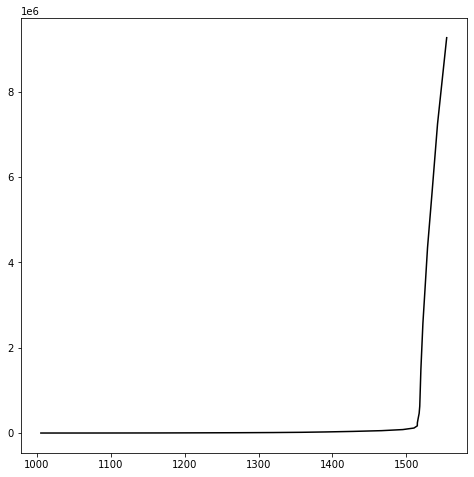

In [103]:
fig,ax = plt.subplots(figsize=(8,8))

init_pres_s = init_pres_1e2_1e7_s
init_temp_s = init_temp_1e2_1e7_s
print(init_pres_s.core_data())
print(init_temp_s.core_data())
ax.plot(init_temp_s.core_data(), init_pres_s.core_data(), color="k")


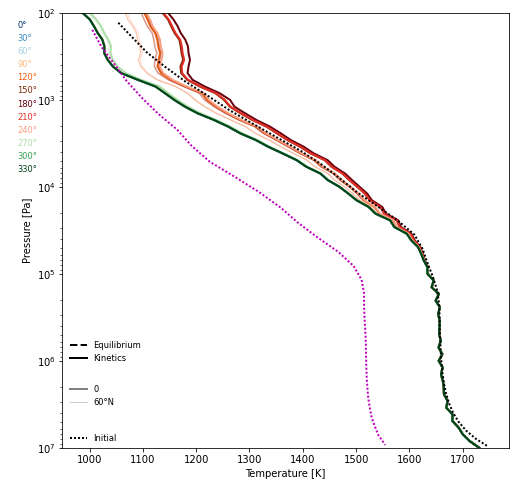

In [104]:
fig,ax = plt.subplots(figsize=(8,8))
ax.set_yscale("log")
ax.set_ylim(1e7, 1e2)
ax.set_ylabel("Pressure [Pa]")
ax.set_xlabel(f"Temperature [K]")


for lon, clr, clr60 in zip(tgt_lons, lon_clrs, lon_clrs_60):
                vp00 = temp_plevs_locs.extract(iris.Constraint(latitude=0, longitude=lon))
                vp60 = temp_plevs_locs.extract(iris.Constraint(latitude=60, longitude=lon))
                ax.plot(
                    vp00.data,
                    pres_coord.points,
                    #**plt_kw,
                    color=clr,
                    label=f"{int(lon)}°",
                    linewidth=2,
                )
                ax.plot(
                    vp60.data,
                    pres_coord.points,
                    #**plt_kw,
                    color=clr60,
                    label=f"{int(lon)}°",
                    linewidth=1,
                )
                
init_pres = init_pres_1e2_1e7
init_temp = init_temp_1e2_1e7
ax.plot(init_temp.core_data(), init_pres.core_data(), color="k", linewidth=2, linestyle=(0, (1, 1)))

init_pres_s = init_pres_1e2_1e7_s
init_temp_s = init_temp_1e2_1e7_s
ax.plot(init_temp_s.core_data(), init_pres_s.core_data(), color="m", linewidth=2, linestyle=(0, (1, 1)))

# ax.legend(
#     #handles,
#     #labels,
#     loc="upper left",
#     bbox_to_anchor=(-0.04, 1),
#     frameon=False,
#     handlelength=0,
#     fontsize="small",
# )

# Add extra legends
add_custom_legend(
    ax, leg_exp_kw, loc="center left", bbox_to_anchor=(0, 0.22), frameon=False, fontsize="small"
)
add_custom_legend(
    ax, leg_lat_kw, loc="center left", bbox_to_anchor=(0, 0.12), frameon=False, fontsize="small"
)
add_custom_legend(
    ax, leg_init_kw, loc="lower left", bbox_to_anchor=(0, -0.005), frameon=False, fontsize="small"
)
# Add longitudes legend
# Delete repeating handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg = ax.legend(
    handles,
    labels,
    loc="upper right",
    bbox_to_anchor=(-0.04, 1),
    frameon=False,
    handlelength=0,
    fontsize="small",
)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())